In [1]:
import h5py
import scipy
import numpy as np
import os
import zlib
import msgpack
from sklearn.utils import sparsefuncs
import matplotlib.pyplot as plt

def read_compressed_json(json_path):
	if not os.path.isfile(json_path):
		return {}
	with open(json_path, 'rb') as f:
		o = f.read()
		o = zlib.decompress(o)
		o = msgpack.unpackb(o, strict_map_key=False)
		return o

In [2]:
GENES_ANNOTATION = read_compressed_json('/home/ub-sonvo-25d094476064960/genes_annotation.json.gz')
N_GENES = GENES_ANNOTATION['n_genes']
DEFAULT_SIZE_FACTOR = 10000
ROOT_DIR = '/home/ub-sonvo-25d094476064960/celltype_prediction'
TRAINED_STUDIES = open(ROOT_DIR + '/studies_idx_HVG.txt').read().splitlines()

In [48]:
with h5py.File(ROOT_DIR + '/camel/' + TRAINED_STUDIES[8] + '/raw.hdf5') as f:
    indptr = f['expression']['indptr'][()]
    indices = f['expression']['indices'][()]
    data = f['expression']['lognorm'][()]
    bc = f['barcodes'][()]
    fe = f['features'][()]
    raw = f['expression']['raw'][()]

In [71]:
matrix = scipy.sparse.csr_matrix((data, indices, indptr), shape=(len(fe), len(bc)))

In [72]:
matrix = matrix.T.tocsr()

In [73]:
matrix

<146442x64403 sparse matrix of type '<class 'numpy.float32'>'
	with 254317234 stored elements in Compressed Sparse Row format>

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
new_matrix = scaler.fit_transform(matrix.toarray())

In [59]:
for i in range(len(matrix.indptr) - 1):
    start = matrix.indptr[i]
    end = matrix.indptr[i + 1]
    tmp_data = matrix.data[start : end].copy()
    tmp_n_genes = len(tmp_data)
    tmp_sort = np.argsort(tmp_n_genes)
    replaced_data = np.zeros(shape=tmp_n_genes)
    replaced_data[- np.minimum(tmp_n_genes, 2000):] = np.arange(1, 2001)[- np.minimum(tmp_n_genes, 2000):]
    matrix.data[start : end] = replaced_data

In [62]:
matrix = matrix.tocsr()

In [49]:
print(np.nonzero(fe.astype('str') == 'FBLN1')[0][0])
print(np.nonzero(fe.astype('str') == 'C7')[0][0])
print(np.nonzero(fe.astype('str') == 'LUM')[0][0])
print(np.nonzero(fe.astype('str') == 'COL1A1')[0][0])

23235
16406
31925
18428


In [87]:
studies_idx_arr = np.load('trained_data/studies_idx_arr.npy')
meta_arr = np.load('trained_data/trained_meta_celltypes_HVG.npy')

In [88]:
study_bool = studies_idx_arr == 8

In [98]:
tmp_meta = meta_arr[study_bool]
tmp_meta_idx = np.nonzero(tmp_meta == 387)[0]

In [99]:
tmp_meta_idx.shape

(19906,)

In [92]:
new_matrix

array([[-0.00496894,  0.        , -0.15469337, ..., -0.6807422 ,
        -0.0184219 , -0.11067681],
       [-0.00496894,  0.        , -0.15469337, ..., -0.6807422 ,
        -0.0184219 , -0.11067681],
       [-0.00496894,  0.        , -0.15469337, ..., -0.6807422 ,
        -0.0184219 , -0.11067681],
       ...,
       [-0.00496894,  0.        , -0.15469337, ..., -0.6807422 ,
        -0.0184219 , -0.11067681],
       [-0.00496894,  0.        , -0.15469337, ..., -0.6807422 ,
        -0.0184219 , -0.11067681],
       [-0.00496894,  0.        , -0.15469337, ..., -0.6807422 ,
        -0.0184219 , -0.11067681]], dtype=float32)

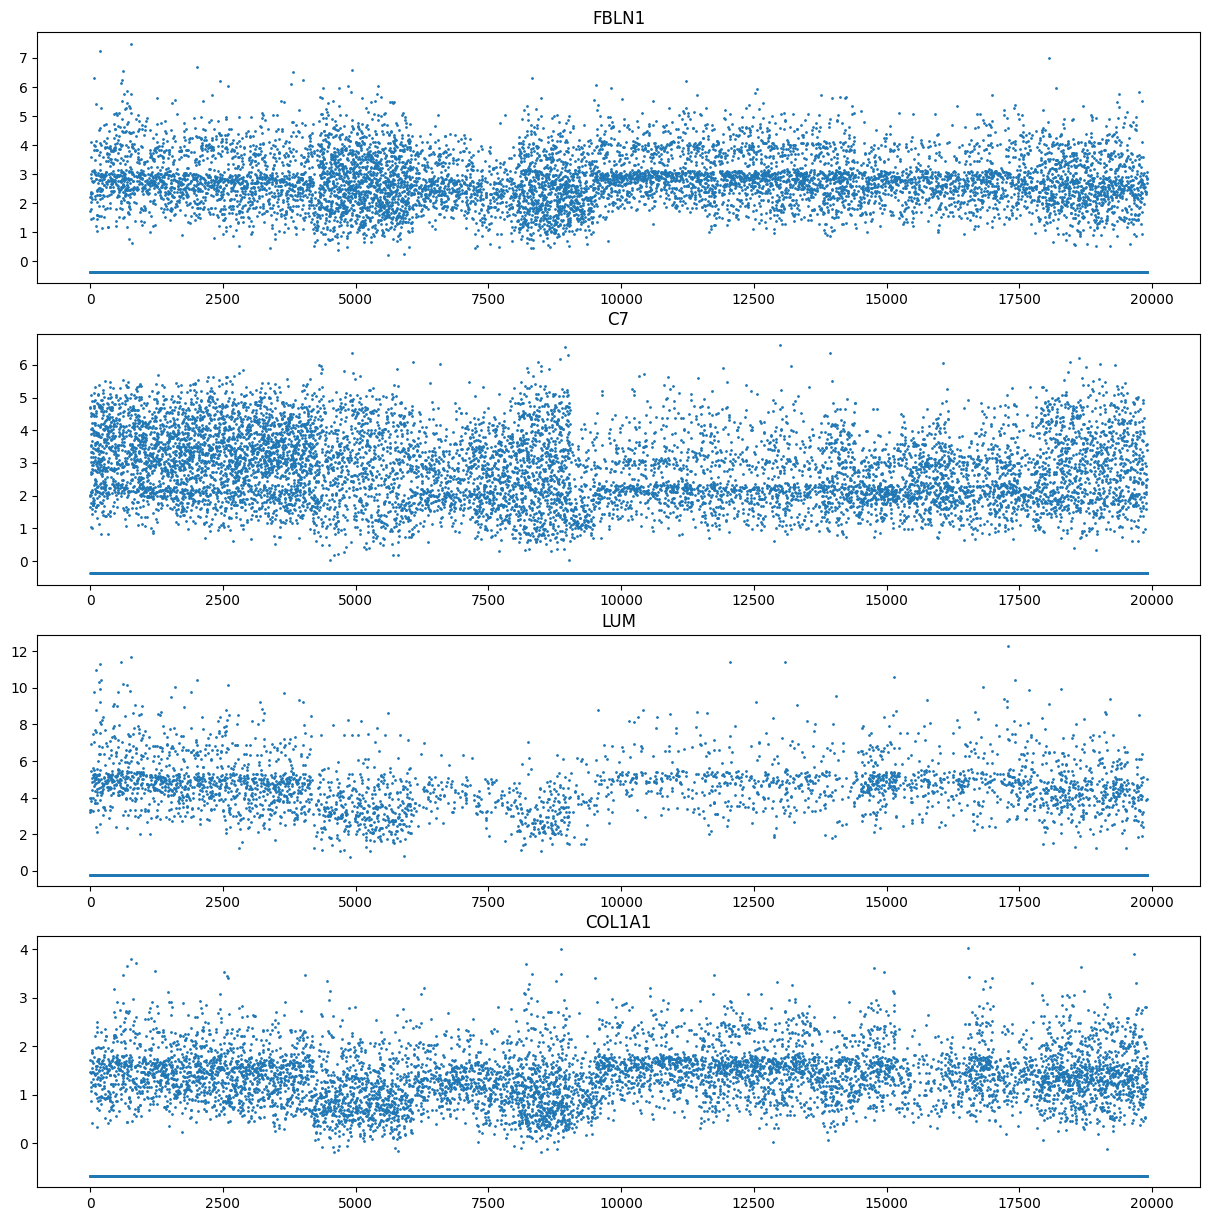

In [93]:
seleted_genes_idx = [23235, 16406, 31925, 18428]
selected_genes_names = ['FBLN1', 'C7', 'LUM', 'COL1A1']
fig, axs = plt.subplots(4, 1, figsize=(15, 15))
for i in range(len(seleted_genes_idx)):
    gene_idx = seleted_genes_idx[i]
    # tmp_indices = matrix.indices[matrix.indptr[gene_idx] : matrix.indptr[gene_idx + 1]]
    # tmp_data = matrix.data[matrix.indptr[gene_idx] : matrix.indptr[gene_idx + 1]]
    # tmp_indices_bool = np.isin(tmp_indices, tmp_meta_idx)
    # tmp_data = tmp_data[tmp_indices_bool]
    # tmp_x = tmp_indices[tmp_indices_bool]
    tmp_data = new_matrix[tmp_meta_idx, gene_idx]
    tmp_x = np.arange(len(tmp_data))
    
    axs[i].scatter(tmp_x, tmp_data, s=1)
    axs[i].set_title(selected_genes_names[i])


# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('C7')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('LUM')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('COL1A1')

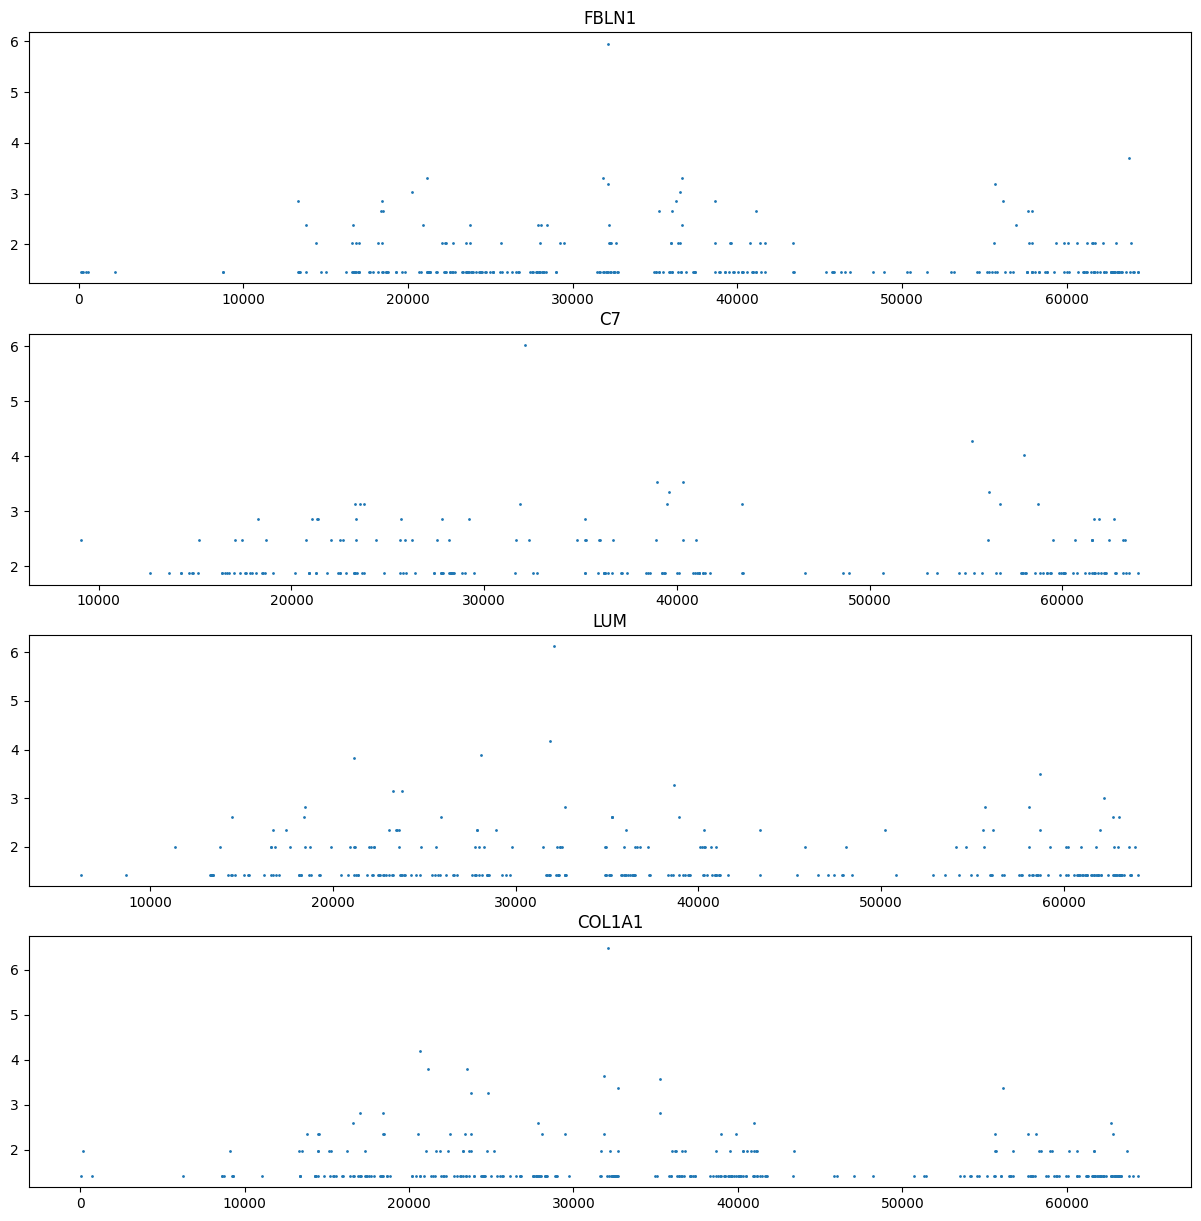

In [95]:
seleted_genes_idx = [23235, 16406, 31925, 18428]
selected_genes_names = ['FBLN1', 'C7', 'LUM', 'COL1A1']
fig, axs = plt.subplots(4, 1, figsize=(15, 15))
for i in range(len(seleted_genes_idx)):
    gene_idx = seleted_genes_idx[i]
    tmp_indices = matrix.indices[matrix.indptr[gene_idx] : matrix.indptr[gene_idx + 1]]
    tmp_data = matrix.data[matrix.indptr[gene_idx] : matrix.indptr[gene_idx + 1]]
    tmp_indices_bool = np.isin(tmp_indices, tmp_meta_idx)
    tmp_data = tmp_data[tmp_indices_bool]
    tmp_x = tmp_indices[tmp_indices_bool]
    
    axs[i].scatter(tmp_x, tmp_data, s=1)
    axs[i].set_title(selected_genes_names[i])

In [13]:
mtx = scipy.sparse.csr_matrix((raw, indices, indptr), shape=(len(fe), len(bc)))

In [14]:
mtx = mtx.tocsc()

In [4]:
def check_raw_or_lognorm_matrix(hdf5_path):
    with h5py.File(hdf5_path) as f:
        indptr = f['expression']['indptr'][()]
        indices = f['expression']['indices'][()]
        if 'raw' not in f['expression'].keys():
            print ('!!!!!!WARNING!!!!!!')
            print ('DOES NOT have "raw" values')
            raw = f['expression']['lognorm'][()].astype(np.float32)
        else:
            raw = f['expression']['raw'][()].astype(np.float32)
        barcodes = f['barcodes'][()]
        features = f['features'][()]

    matrix = scipy.sparse.csr_matrix(
        (raw, indices, indptr), shape=(len(features), len(barcodes))
    ).T.tocsr()

    is_raw_matrix = False
    if (np.sum(raw > 30) > 0 and not np.all(raw.astype('int') == raw)) or np.all(raw.astype('int') == raw):
        is_raw_matrix = True

    return matrix, is_raw_matrix, barcodes, features, len(indices)

In [5]:
def _normalize_total(csr_matrix, counts):
	csr_matrix = csr_matrix.astype(np.float32)
	counts += counts == 0
	counts = counts / 10000
	sparsefuncs.inplace_row_scale(csr_matrix, 1 / counts)
	return csr_matrix


def normalize_total(csr_cxg, n_genes=N_GENES):
    csr_cxg = csr_cxg[:, :n_genes]
    counts_per_cell = csr_cxg.sum(1)
    counts_per_cell = np.ravel(counts_per_cell)
    
    csr_cxg = _normalize_total(csr_cxg, counts_per_cell)
    csr_cxg.data = np.log1p(csr_cxg.data)
    
    return csr_cxg


def convert_library_size(csr_cxg, n_genes=N_GENES, size_factor=DEFAULT_SIZE_FACTOR):
    res = []
    for i in range(50):
        res.append(
            np.sum(
                np.expm1(
                    csr_cxg.data[csr_cxg.indptr[i] : csr_cxg.indptr[i+1]]
                )
            )
        )
    res = [np.round(i) for i in res]
    ori_size_factor = np.unique(res)
    upper_bound = ori_size_factor[0] + ori_size_factor[0] * 0.1
    lower_bount = ori_size_factor[0] - ori_size_factor[0] * 0.1

    if np.all(ori_size_factor > lower_bount) and np.all(ori_size_factor < upper_bound):
        csr_cxg = csr_cxg[:, :n_genes]
        if DEFAULT_SIZE_FACTOR < upper_bound and DEFAULT_SIZE_FACTOR > lower_bount:
            return csr_cxg
            
        csr_cxg.data = np.expm1(csr_cxg.data)
        csr_cxg.data = csr_cxg.data * (DEFAULT_SIZE_FACTOR / ori_size_factor[0])
        csr_cxg.data = np.log1p(csr_cxg.data)
        return csr_cxg
        
    print('cannot find the library size:', ori_size_factor)
    return None

In [6]:
def standarized_matrix(study_idx):
    print ('start', study_idx)
    hdf5_path = os.path.join(ROOT_DIR, 'camel', str(study_idx), 'raw.hdf5')
    matrix, is_raw, barcodes, features, indices_len = check_raw_or_lognorm_matrix(hdf5_path)
    if is_raw:
        matrix = normalize_total(matrix)
    else:
        matrix = convert_library_size(matrix)
    if matrix is None:
        print('FAILED!!!!!:', study_idx)
        return None, None
    return matrix, len(barcodes), indices_len

In [ ]:
for i in 

In [7]:
import multiprocessing as mp

with mp.Pool(20) as pool:
    res = pool.map(standarized_matrix, TRAINED_STUDIES)

startstartstartstart startstart start start1700startstartstart  start1629startstart start
 start  startstartstart1714  1848
1734   1783 18572252 1891   2396
1895
start
2140
239722162423

2507
243225422410







 

1805
start 2615
start 2664
start 2719
start 2745
start 2793
!!!!!!WARNING!!!!!!
DOES NOT have "raw" values
start 2818
start 2836
start 2871
start 2872
start 2893
start 2900
start 2920
start 2969
!!!!!!WARNING!!!!!!
DOES NOT have "raw" values
start 2973
start 3047
start 3054
start 3090
start 3099
start 2421
start 2539
!!!!!!WARNING!!!!!!
DOES NOT have "raw" values


In [8]:
len_indices = 0
for i in res:
    len_indices += i[2]

In [2]:
res

NameError: name 'res' is not defined

In [12]:
len_indices = 0
for i in res:
    len_indices += len(i[0].indices)

len_indices

8954075312

In [9]:
n_cells = 0
for i in res:
    n_cells += i[1]

In [34]:
n_cells

5033871

In [10]:
n_cells

5033871

In [32]:
len_indices

8954075312

In [11]:
len_indices

8969132429

In [23]:
test_mtx = res[0][0]

In [24]:
test_mtx.indptr

array([        0,      1898,      3107, ..., 549970781, 549972516,
       549973703], dtype=int32)

In [27]:
test_mtx.indices.shape

(549973703,)

In [31]:
np.iinfo(np.uint16)

iinfo(min=0, max=65535, dtype=uint16)

In [35]:
indptr = np.zeros(shape=n_cells+1, dtype=np.uint64)
indices = np.zeros(shape=len_indices, dtype=np.uint16)
data = np.zeros(shape=len_indices, dtype=np.float32)
genes_bool = np.ones(shape=N_GENES).astype(np.bool_)

offset_indptr = 1
offset_indices = 0
all_n_cells = 0
all_n_indices = 0
for i in range(len(res)):
    print (i)
    matrix, tmp_n_cells, tmp_indices_len = res[i]
    if tmp_n_cells is None:
        print ('None', i)
        continue
    tmp_indptr = matrix.indptr.astype(np.uint64)[1:]
    tmp_indices = matrix.indices.astype(np.uint16)
    tmp_data = matrix.data.astype(np.float32)
    
    indptr[offset_indptr : offset_indptr + len(tmp_indptr)] += tmp_indptr + np.max(indptr)
    offset_indptr += len(tmp_indptr)
    
    indices[offset_indices : offset_indices + len(tmp_indices)] += tmp_indices
    data[offset_indices : offset_indices + len(tmp_indices)] += tmp_data
    offset_indices += len(tmp_indices)

    tmp_genes_bool = np.array(matrix.sum(axis=0))[0] > 0
    genes_bool = np.logical_and(genes_bool, tmp_genes_bool)
    all_n_cells += tmp_n_cells
    all_n_indices += tmp_indices_len

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [36]:
indptr

array([         0,       1898,       3107, ..., 8954074554, 8954074886,
       8954075312], dtype=uint64)

In [38]:
indices.shape

(8954075312,)

In [18]:
data.shape

(8954075312,)

In [39]:
np.save('trained_data/indptr.npy', indptr)
np.save('trained_data/indices.npy', indices)
np.save('trained_data/data.npy', data)

In [40]:
np.save('trained_data/genes_bool.npy', genes_bool)